In [11]:
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from matplotlib.dates import DateFormatter
from scipy.ndimage import gaussian_filter, zoom


billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100.head()

Unnamed: 0 first_day_of_the_week                         artist  \
0           0            1958-09-08               Domenico Modugno   
1           1            1958-09-08                   The Elegants   
2           2            1958-09-08            The Everly Brothers   
3           3            1958-09-08  Jimmy Clanton And His Rockets   
4           4            1958-09-08  Perez Prado And His Orchestra   

                         song_name  position  last_week_position  \
0  Nel Blu Dipinto Di Blu (Volare)         1                 1.0   
1                      Little Star         2                 2.0   
2                         Bird Dog         3                 3.0   
3                     Just A Dream         4                 4.0   
4                         Patricia         5                 6.0   

   peak_position  weeks_on_chart             songwriters   producers  \
0              1               6  F.Migliacci, D.Modugno  Not Listed   
1              1               6      V.Picone, A.Venosa  Not Listed   
2              3               6                B.Bryant  Not Listed   
3              4               6              Not Listed  Not Listed   
4              2               6       B.Marcus, P.Prado  Not Listed   

  promotion_label  year  
0           Decca  1958  
1             Apt  1958  
2         Cadence  1958  
3             Ace  1958  
4      RCA Victor  1958

In [12]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.rcParams.update({'font.size': 15})

## Distribution of position changes for decades

In [13]:
from datetime import timedelta

grouped = billboard_hot_100.groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "position_rised": 0,
                "weeks_on_chart": row["weeks_on_chart"]
            })

billboard_hot_100_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

In [14]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

billboard_hot_100_with_disappeared_songs["position_change"] = billboard_hot_100_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

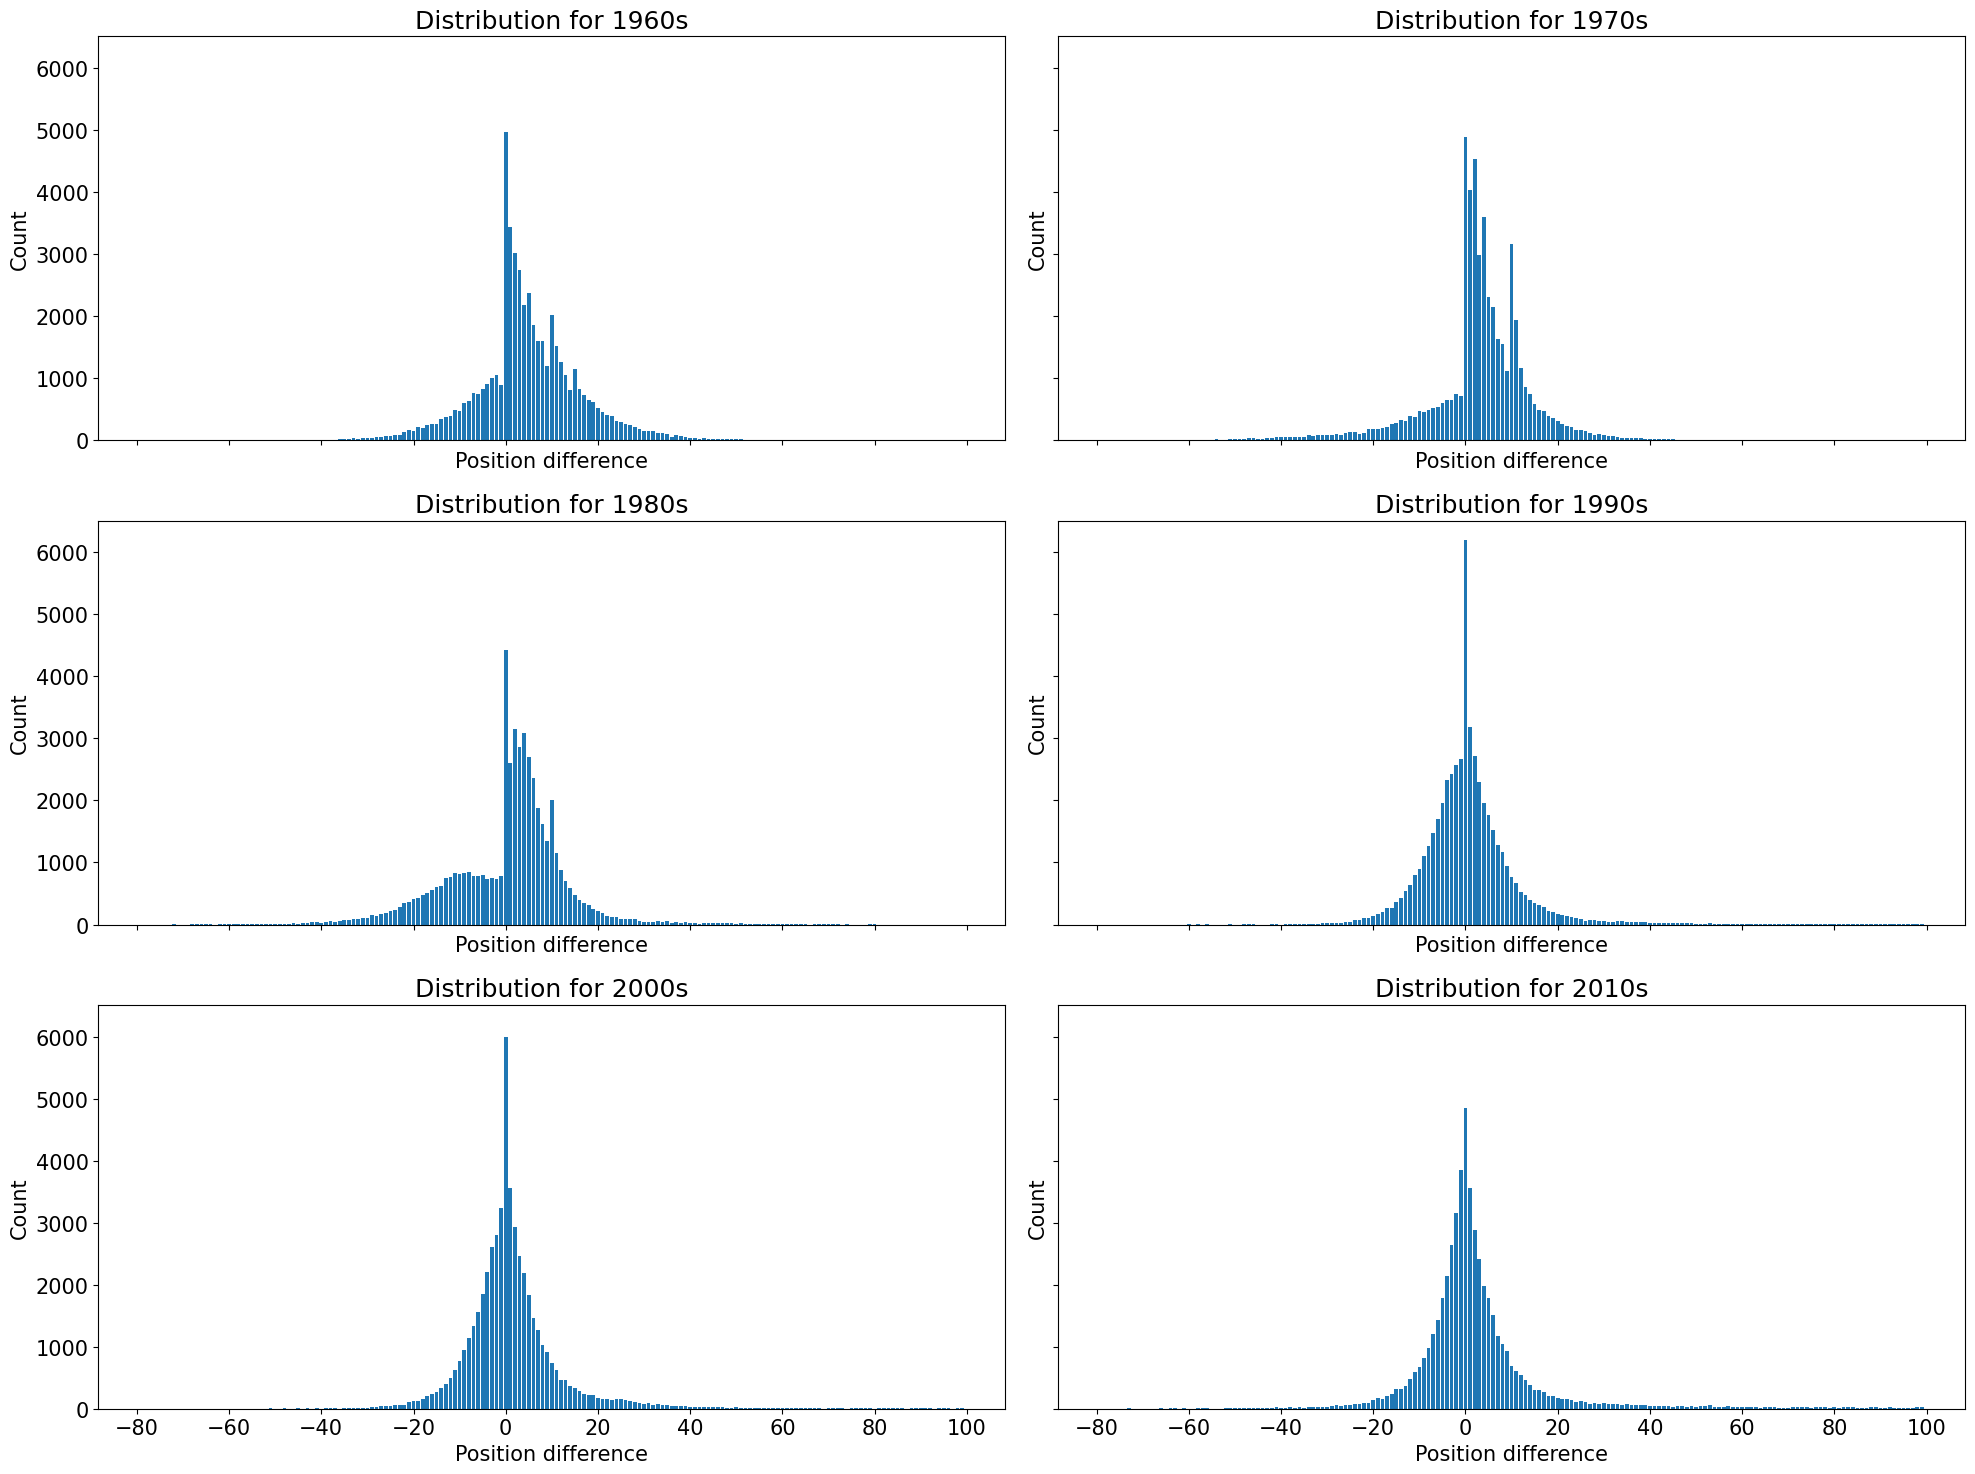

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True, sharey=True)

row = 0
col = 0

billboard_subset = billboard_hot_100_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1960, 2020, 10):
    count_changes = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]["position_change"].value_counts().sort_index()

    axes[row, col].bar(count_changes.index, count_changes.values)
    axes[row, col].set_title(f"Distribution for {year}s")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Count")
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    col += 1
    if col == 2:
        col = 0
        row += 1

plt.locator_params(axis='x', nbins=10)
fig.tight_layout()
plt.savefig("figures/position_difference_distribution_decades.pdf", format="pdf")
plt.show()

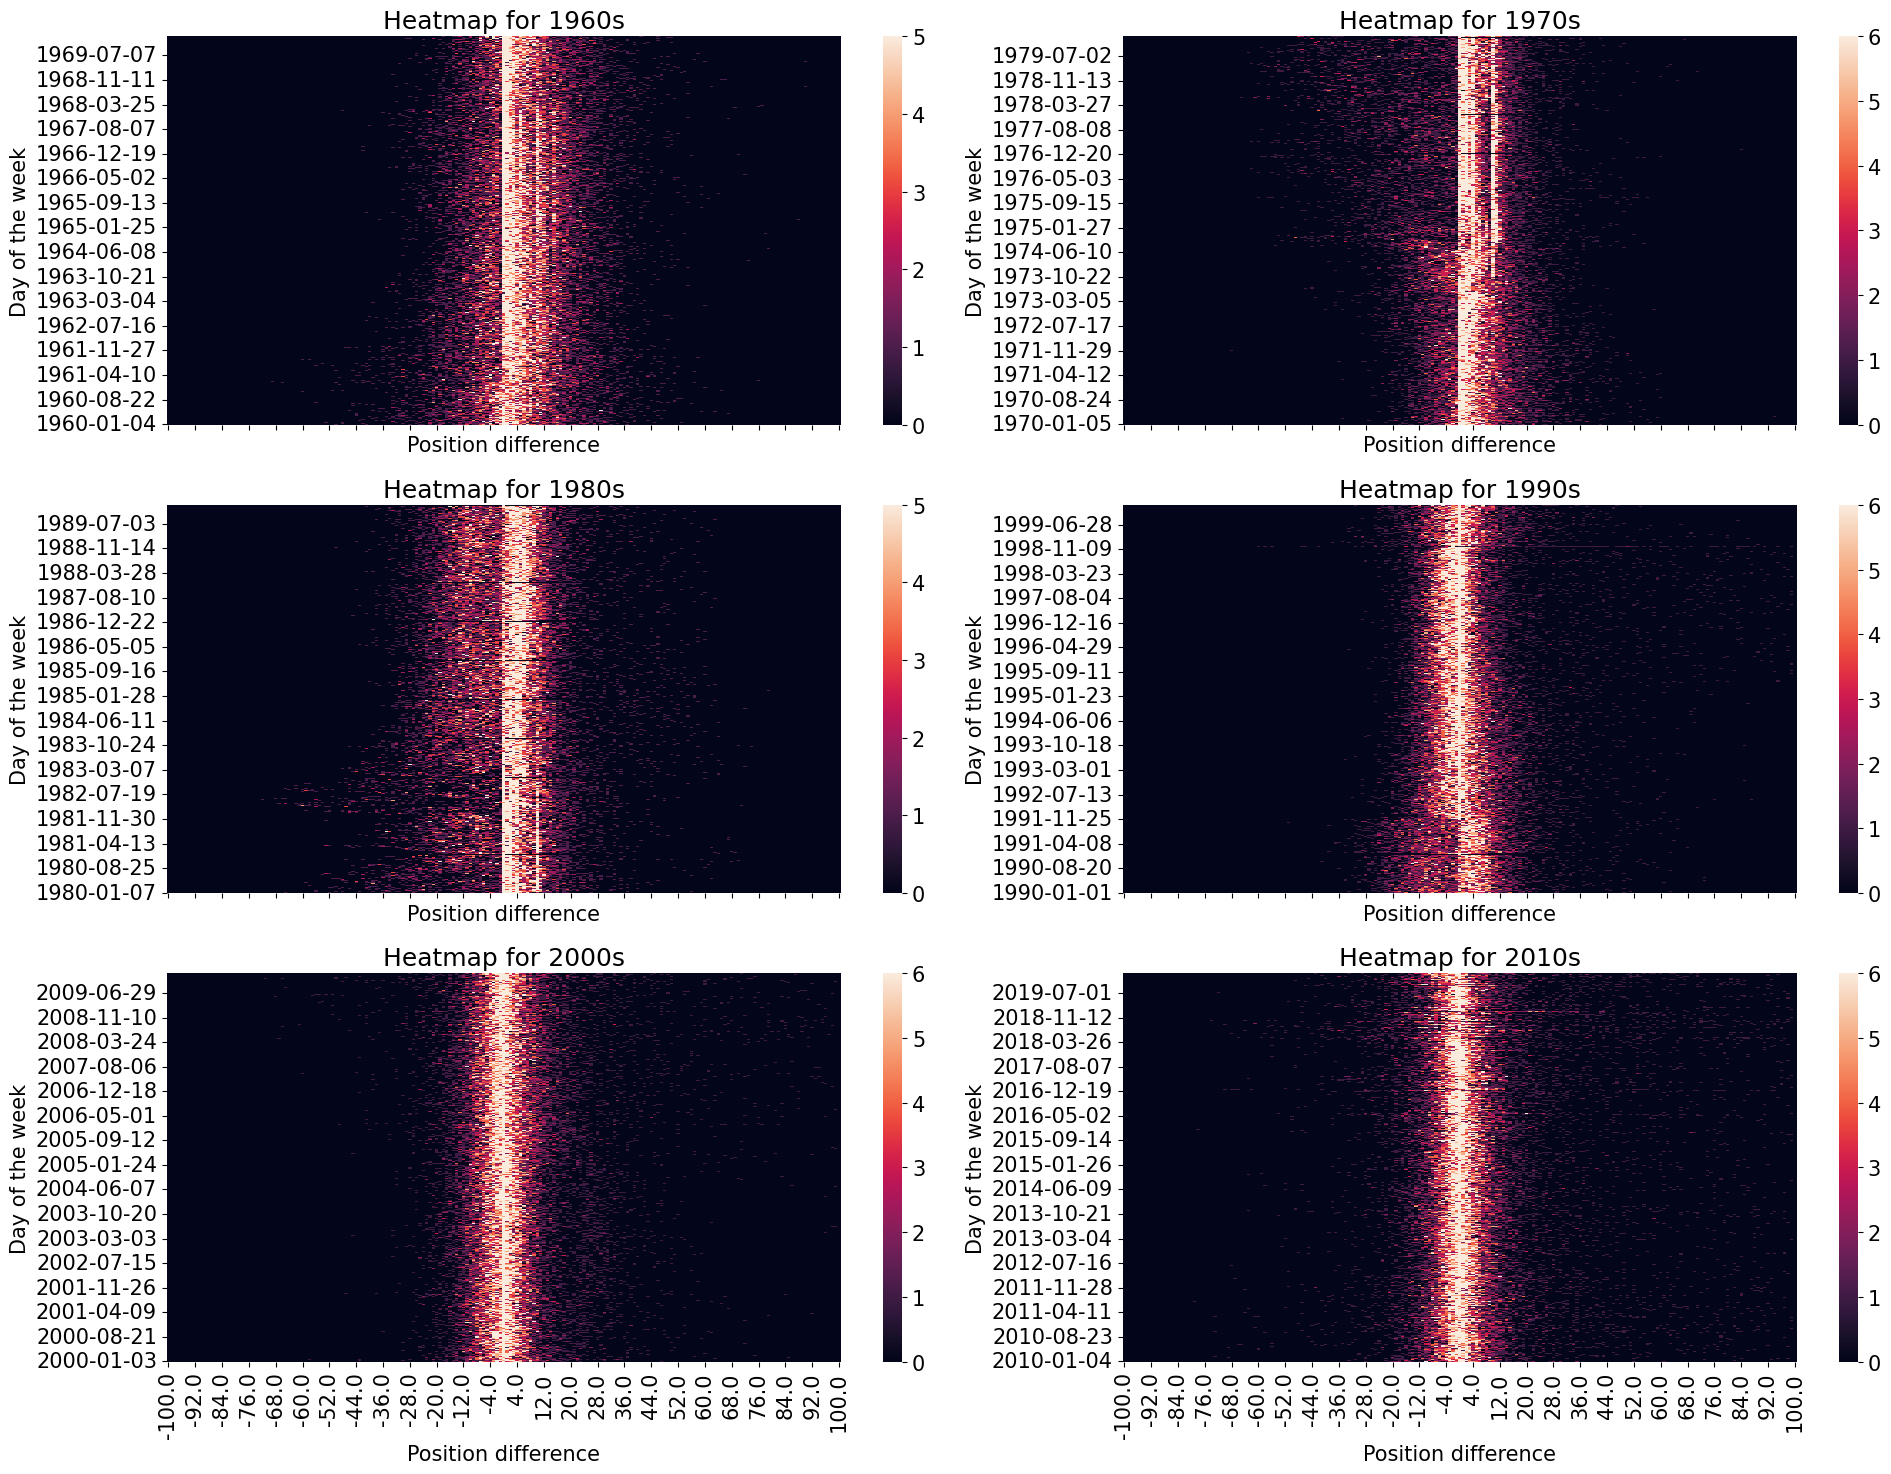

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True)

row = 0
col = 0

for year in range(1960, 2020, 10):
    billboard_year_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]
    cross_tab = pd.crosstab(billboard_year_subset["first_day_of_the_week"], 
                            billboard_year_subset["position_change"])
    # adding the non existing values between -100 and 100 as columns with 0 values to present in the heatmap
    not_existing = []
    for i in range(-100, 101):
        if i not in cross_tab.columns:
            not_existing.append(i)
    not_existing_dict = dict.fromkeys(not_existing, 0)        
    temp_df = pd.DataFrame(not_existing_dict, index=cross_tab.index)
    cross_tab = pd.concat([cross_tab, temp_df], axis=1)
    cross_tab = cross_tab.reindex(sorted(cross_tab.columns), axis=1)

    sns.heatmap(cross_tab, ax=axes[row, col], cmap=sns.color_palette("rocket", as_cmap=True), robust=True)
    axes[row, col].set_title(f"Heatmap for {year}s")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Day of the week")
    axes[row, col].set_ylim(axes[row, col].get_ylim()[::-1])

    labels = [dateutil.parser.parse(item.get_text()).strftime("%Y-%m-%d") for item in axes[row, col].yaxis.get_ticklabels()]
    axes[row, col].set_yticklabels(labels)

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.xticks(rotation=90)
plt.savefig("figures/position_difference_heatmap_decades.pdf", format="pdf")
plt.show()

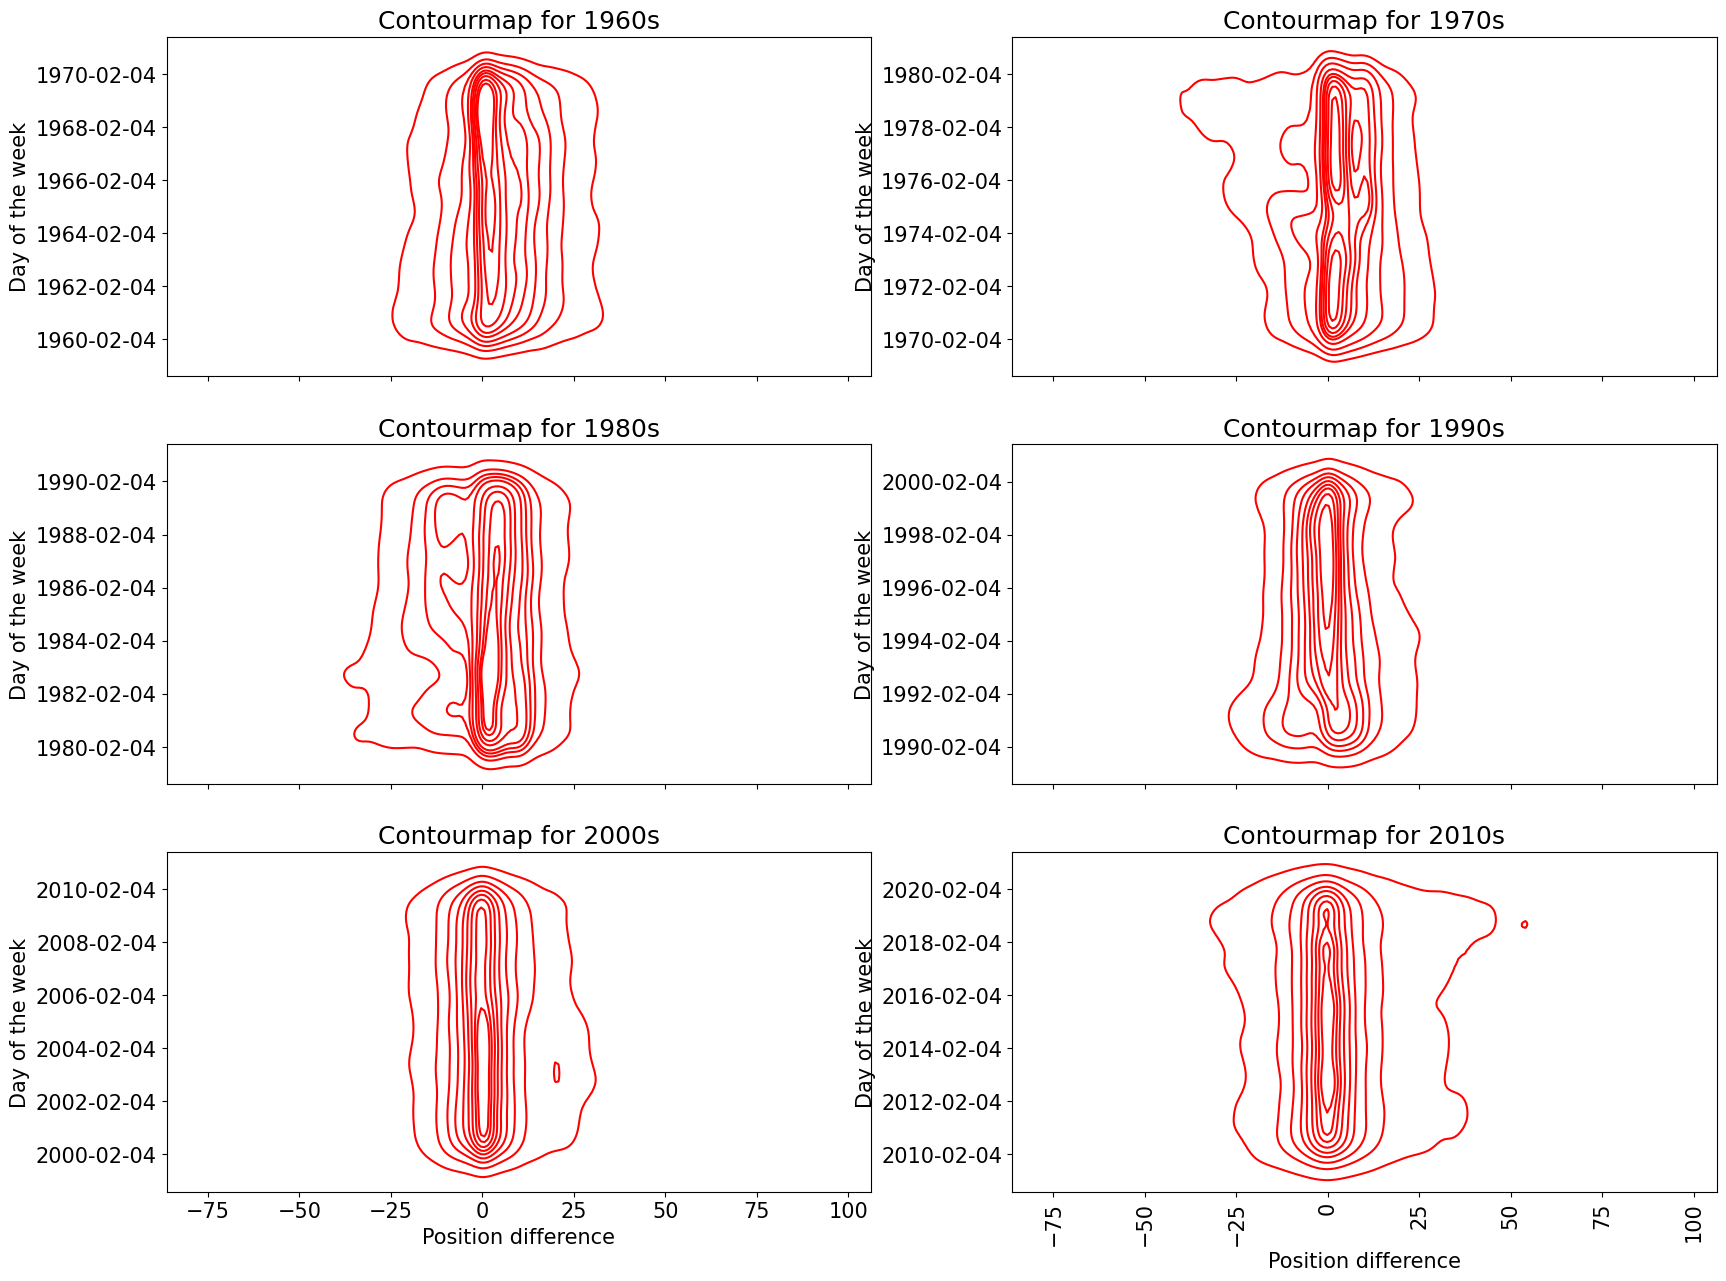

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True)

row = 0
col = 0

for year in range(1960, 2020, 10):
    billboard_year_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]

    sns.kdeplot(billboard_year_subset, x=billboard_year_subset["position_change"], y=billboard_year_subset["first_day_of_the_week"], ax=axes[row, col], color="red")
    axes[row, col].set_title(f"Contourmap for {year}s")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Day of the week")

    labels = [dateutil.parser.parse(item.get_text()).strftime("%Y-%m-%d") for item in axes[row, col].get_yticklabels()]
    # workaround: https://stackoverflow.com/questions/63723514/userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator
    ticks_loc = axes[row, col].get_yticks().tolist()
    axes[row, col].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_yticklabels(labels)

    col += 1
    if col == 2:
        col = 0
        row += 1

plt.xticks(rotation=90)
plt.savefig("figures/position_difference_contourmap_decades.pdf", format="pdf")
plt.show()

## Proportion of songs older than x for decades

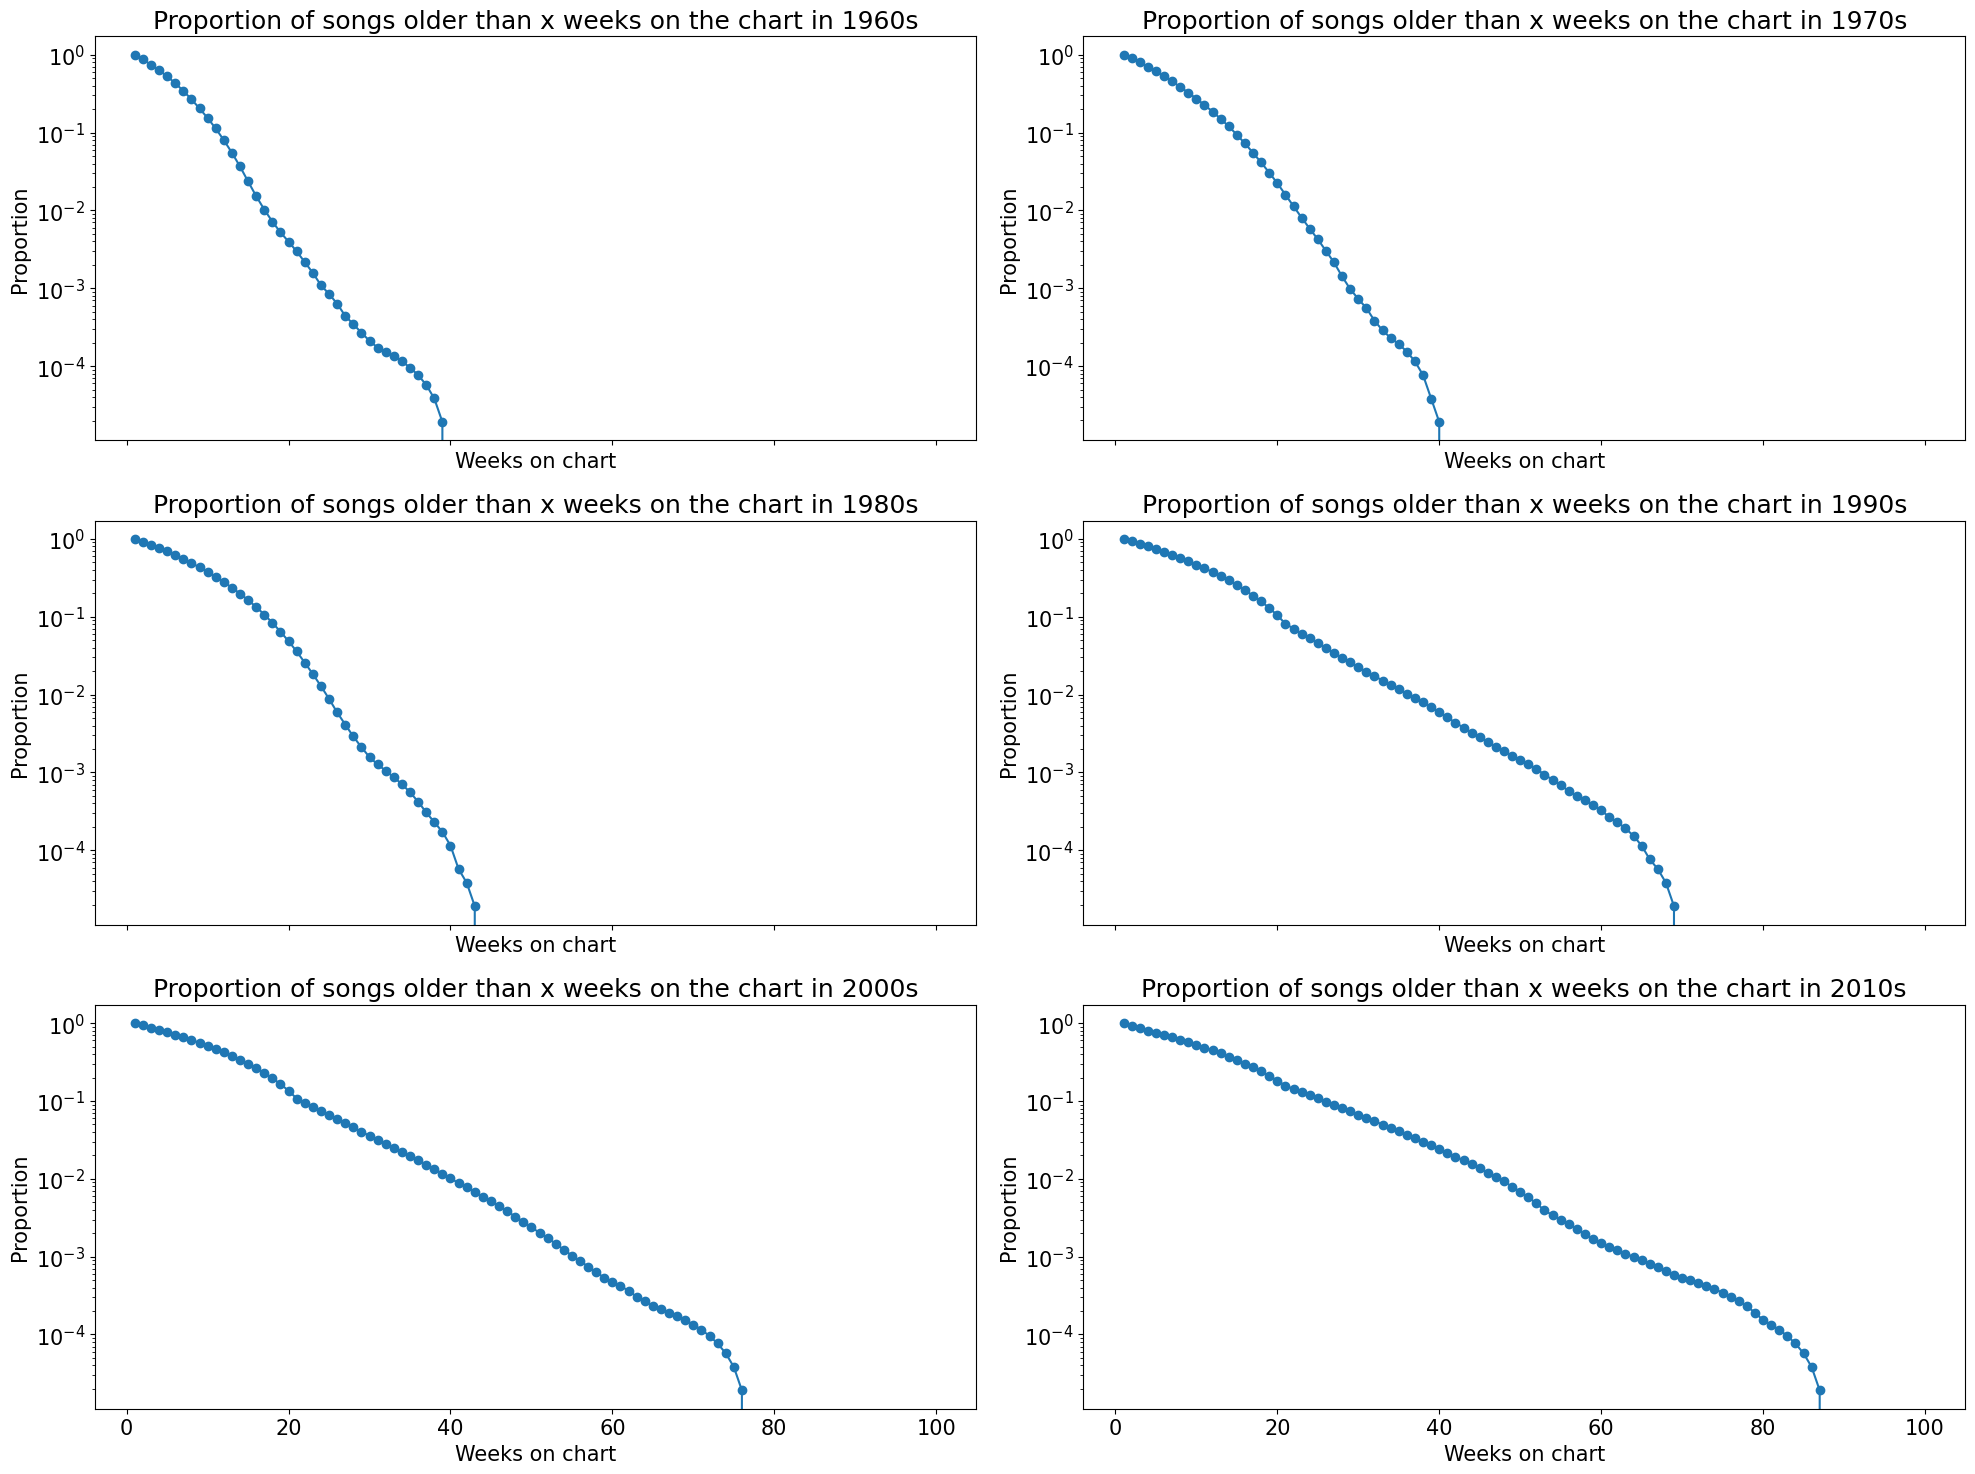

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    proportion_of_songs_older_than_x_weeks = []
    for i in range(1, 101):
        proportion_of_songs_older_than_x_weeks.append(
            billboard_hot_100[(billboard_hot_100["weeks_on_chart"] >= i) & (billboard_hot_100["year"] >= year) &\
                 (billboard_hot_100["year"] < year + 10)].shape[0] / billboard_hot_100[(billboard_hot_100["year"] >= year) &\
                 (billboard_hot_100["year"] < year + 10)].shape[0])
    axes[row, col].plot(range(1, 101), proportion_of_songs_older_than_x_weeks, marker='o')
    axes[row, col].set_title(f"Proportion of songs older than x weeks on the chart in {year}s")
    axes[row, col].set_xlabel("Weeks on chart")
    axes[row, col].set_ylabel("Proportion")
    axes[row, col].set_yscale("log")

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.savefig("figures/proportion_of_songs_older_than_x_weeks_decades.pdf", format="pdf")
plt.show()

## Position trajcetories of top 10 songs for decades

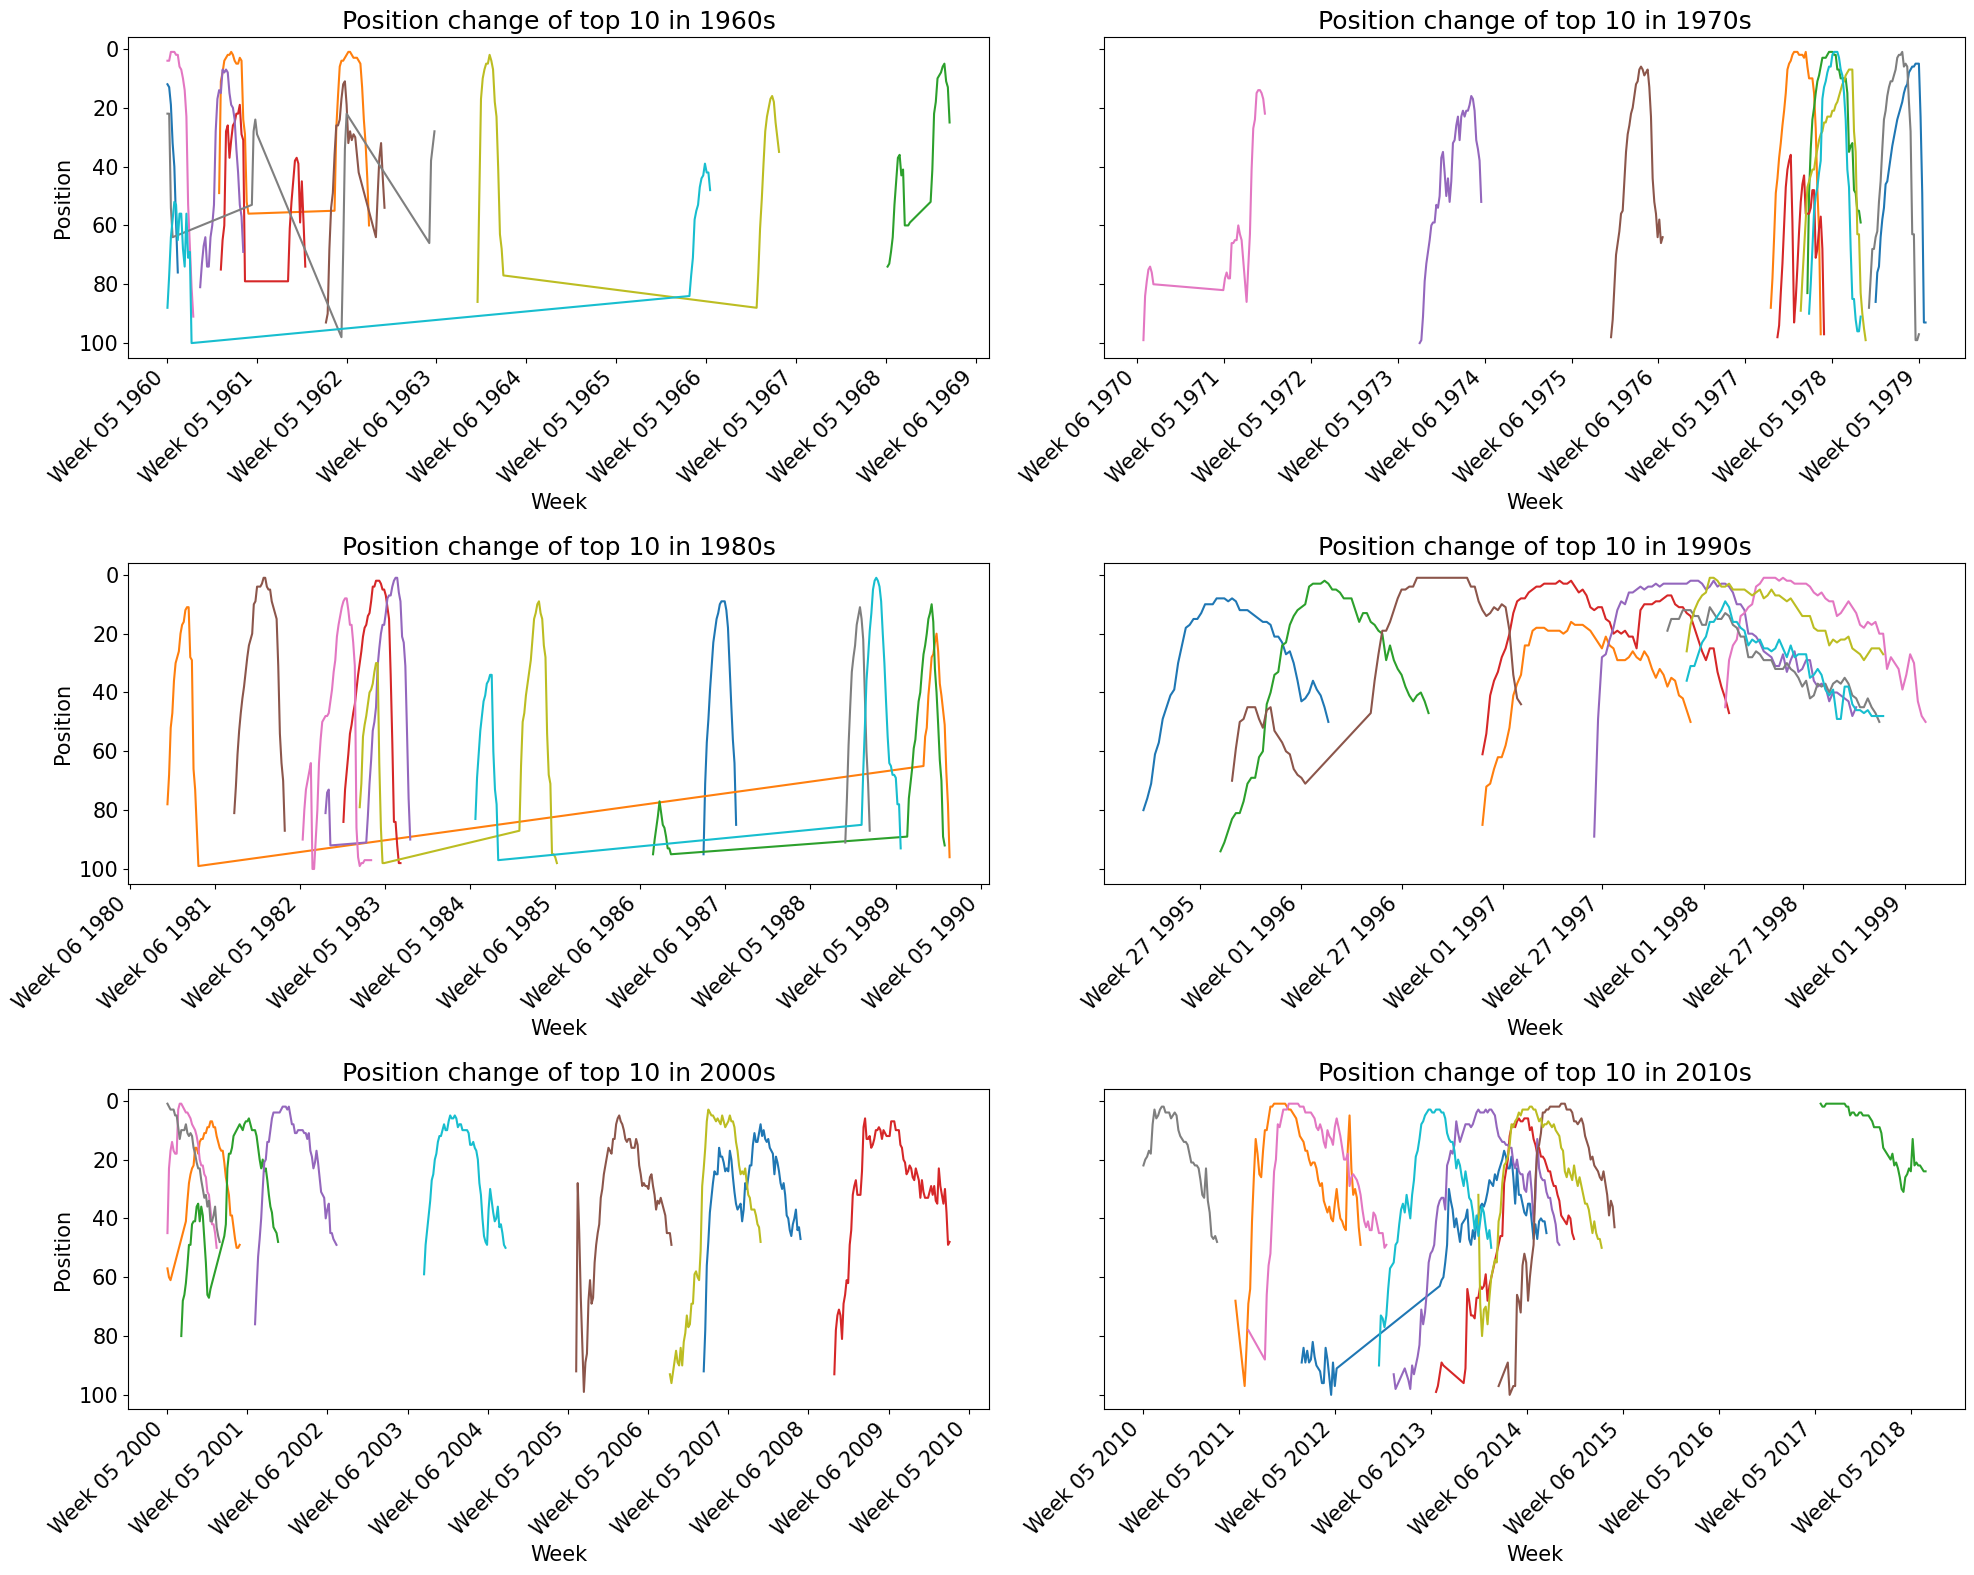

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade.sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)], on=["artist", "song_name"], how="left")

    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    top_10_decade_positions.groupby(by=["artist", "song_name"])["position"].plot(
        kind="line", legend=False, rot=0, ax=axes[row, col])

    axes[row, col].set_title(f"Position change of top 10 in {year}s")
    axes[row, col].set_xlabel("Week")
    axes[row, col].set_ylabel("Position")

    labels = ["Week " + dateutil.parser.parse(item.get_text()).strftime("%V %Y") for item in axes[row, col].get_xticklabels()]
    ticks_loc = axes[row, col].get_xticks().tolist()
    axes[row, col].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_xticklabels(labels, rotation=45)

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_positions_decades.pdf", format="pdf")
plt.show()

### Taking into consideration years before and after the decade

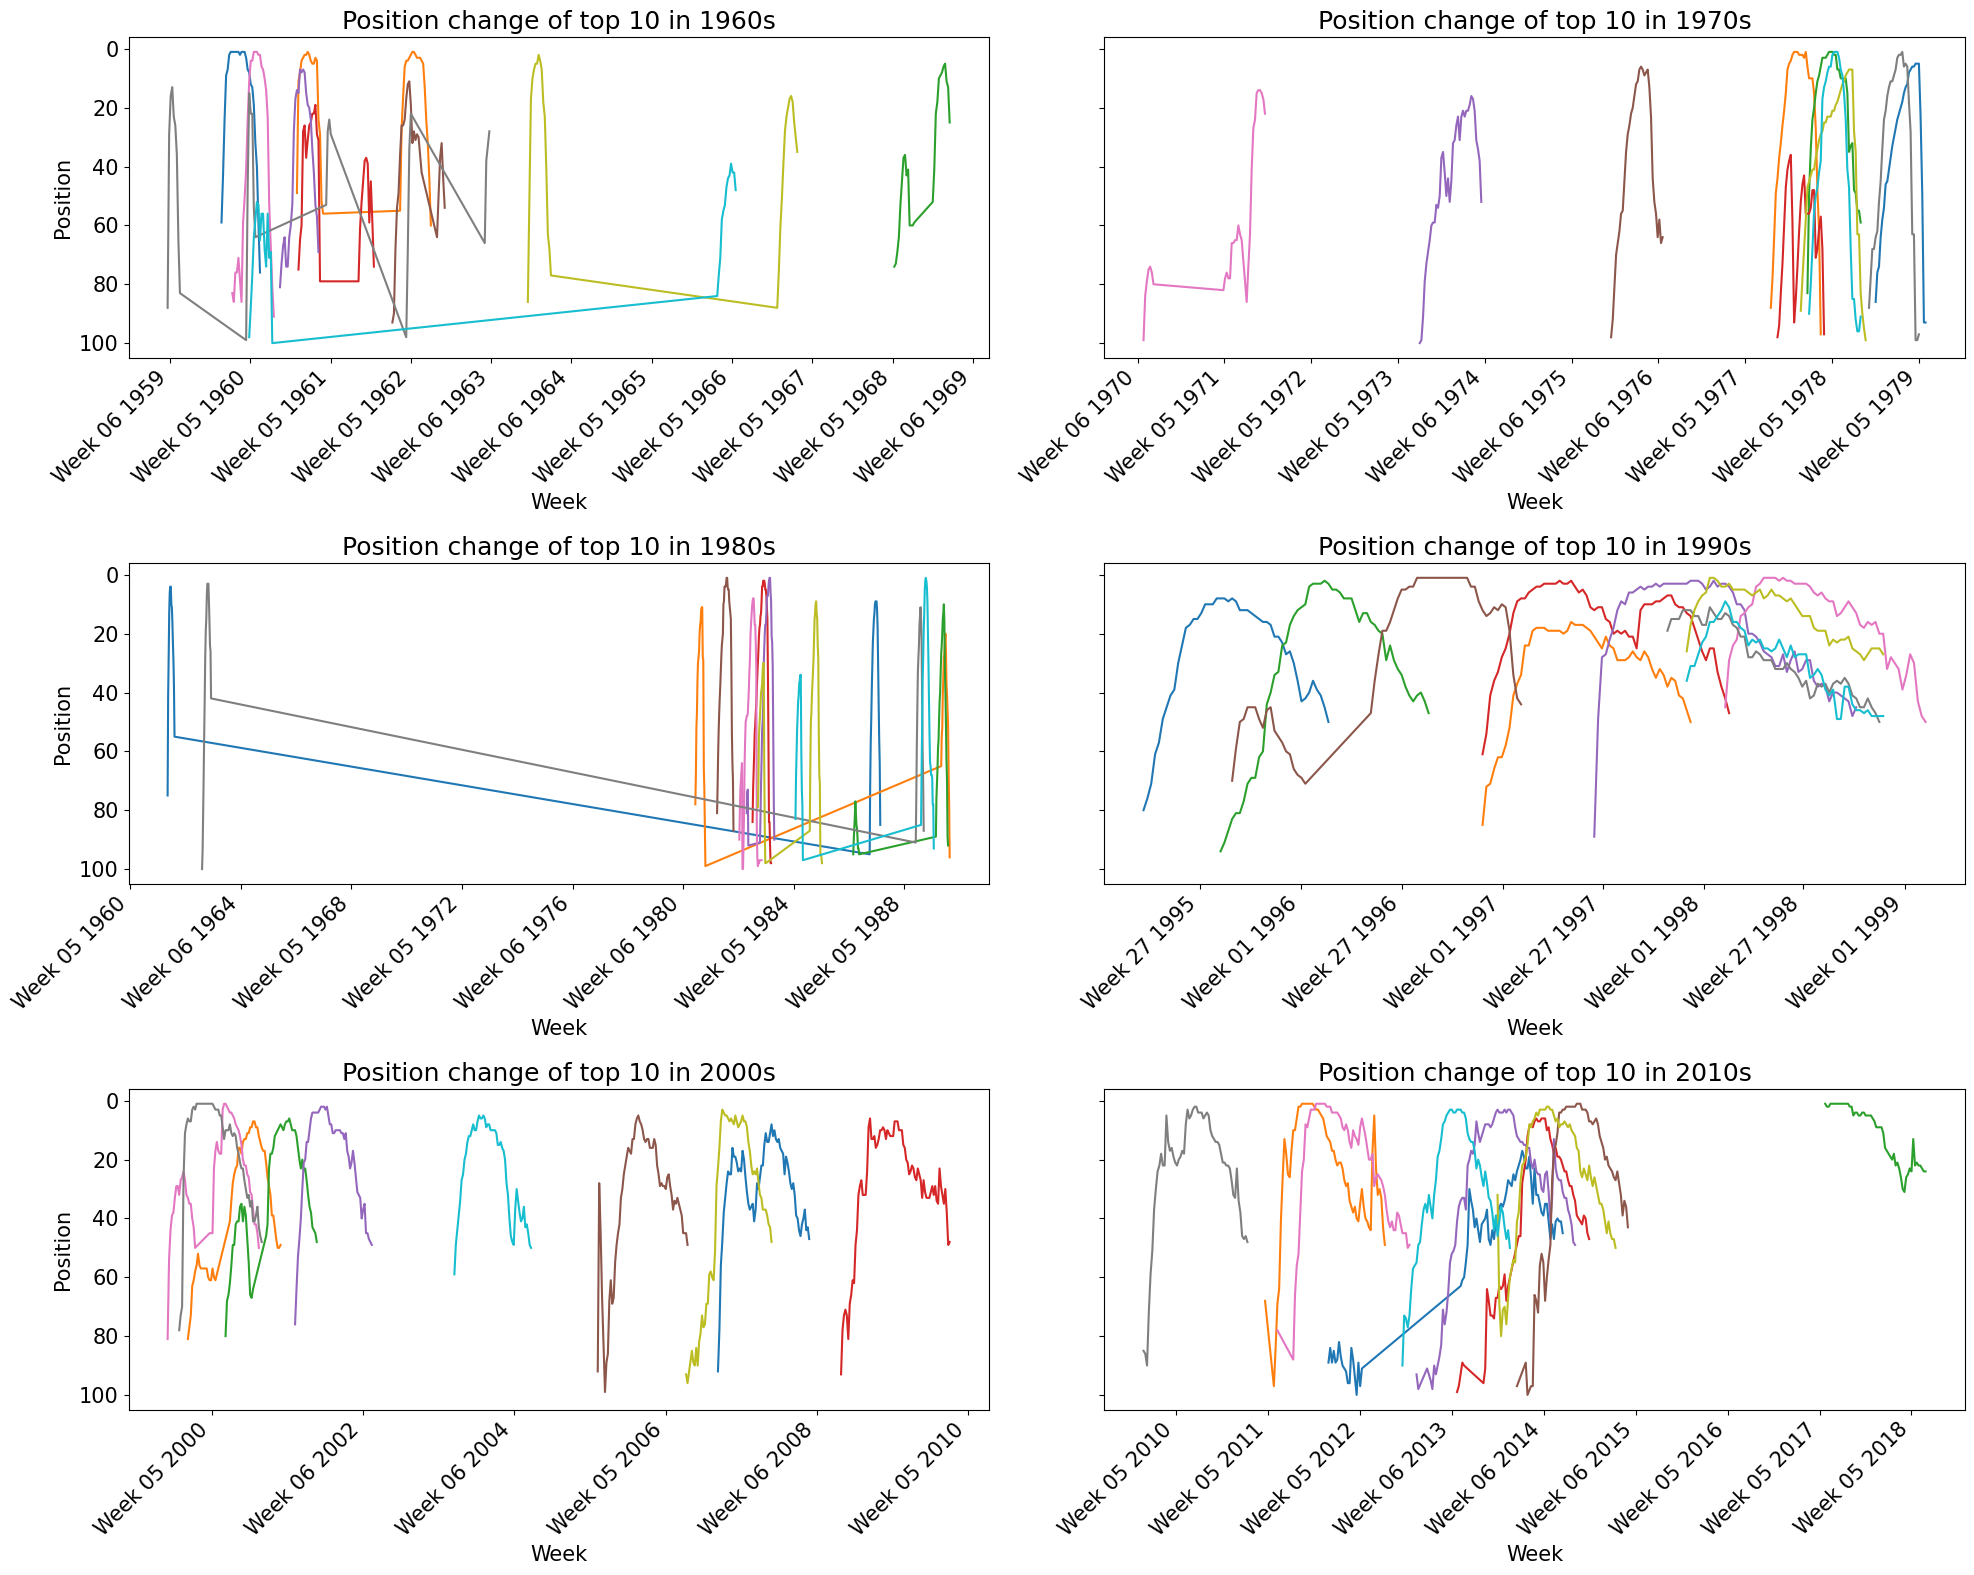

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade.sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100, on=["artist", "song_name"], how="left")

    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    top_10_decade_positions.groupby(by=["artist", "song_name"])["position"].plot(
        kind="line", legend=False, rot=0, ax=axes[row, col])

    axes[row, col].set_title(f"Position change of top 10 in {year}s")
    axes[row, col].set_xlabel("Week")
    axes[row, col].set_ylabel("Position")

    labels = ["Week " + dateutil.parser.parse(item.get_text()).strftime("%V %Y") for item in axes[row, col].get_xticklabels()]
    ticks_loc = axes[row, col].get_xticks().tolist()
    axes[row, col].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_xticklabels(labels, rotation=45)

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_positions_decades_all_years.pdf", format="pdf")
plt.show()

## Projection trajectory of a song normalized from top 10 for decades

In [21]:
# Ben E. King Stand By Me - reappeared on the chart in 1986
# and was created in 1961

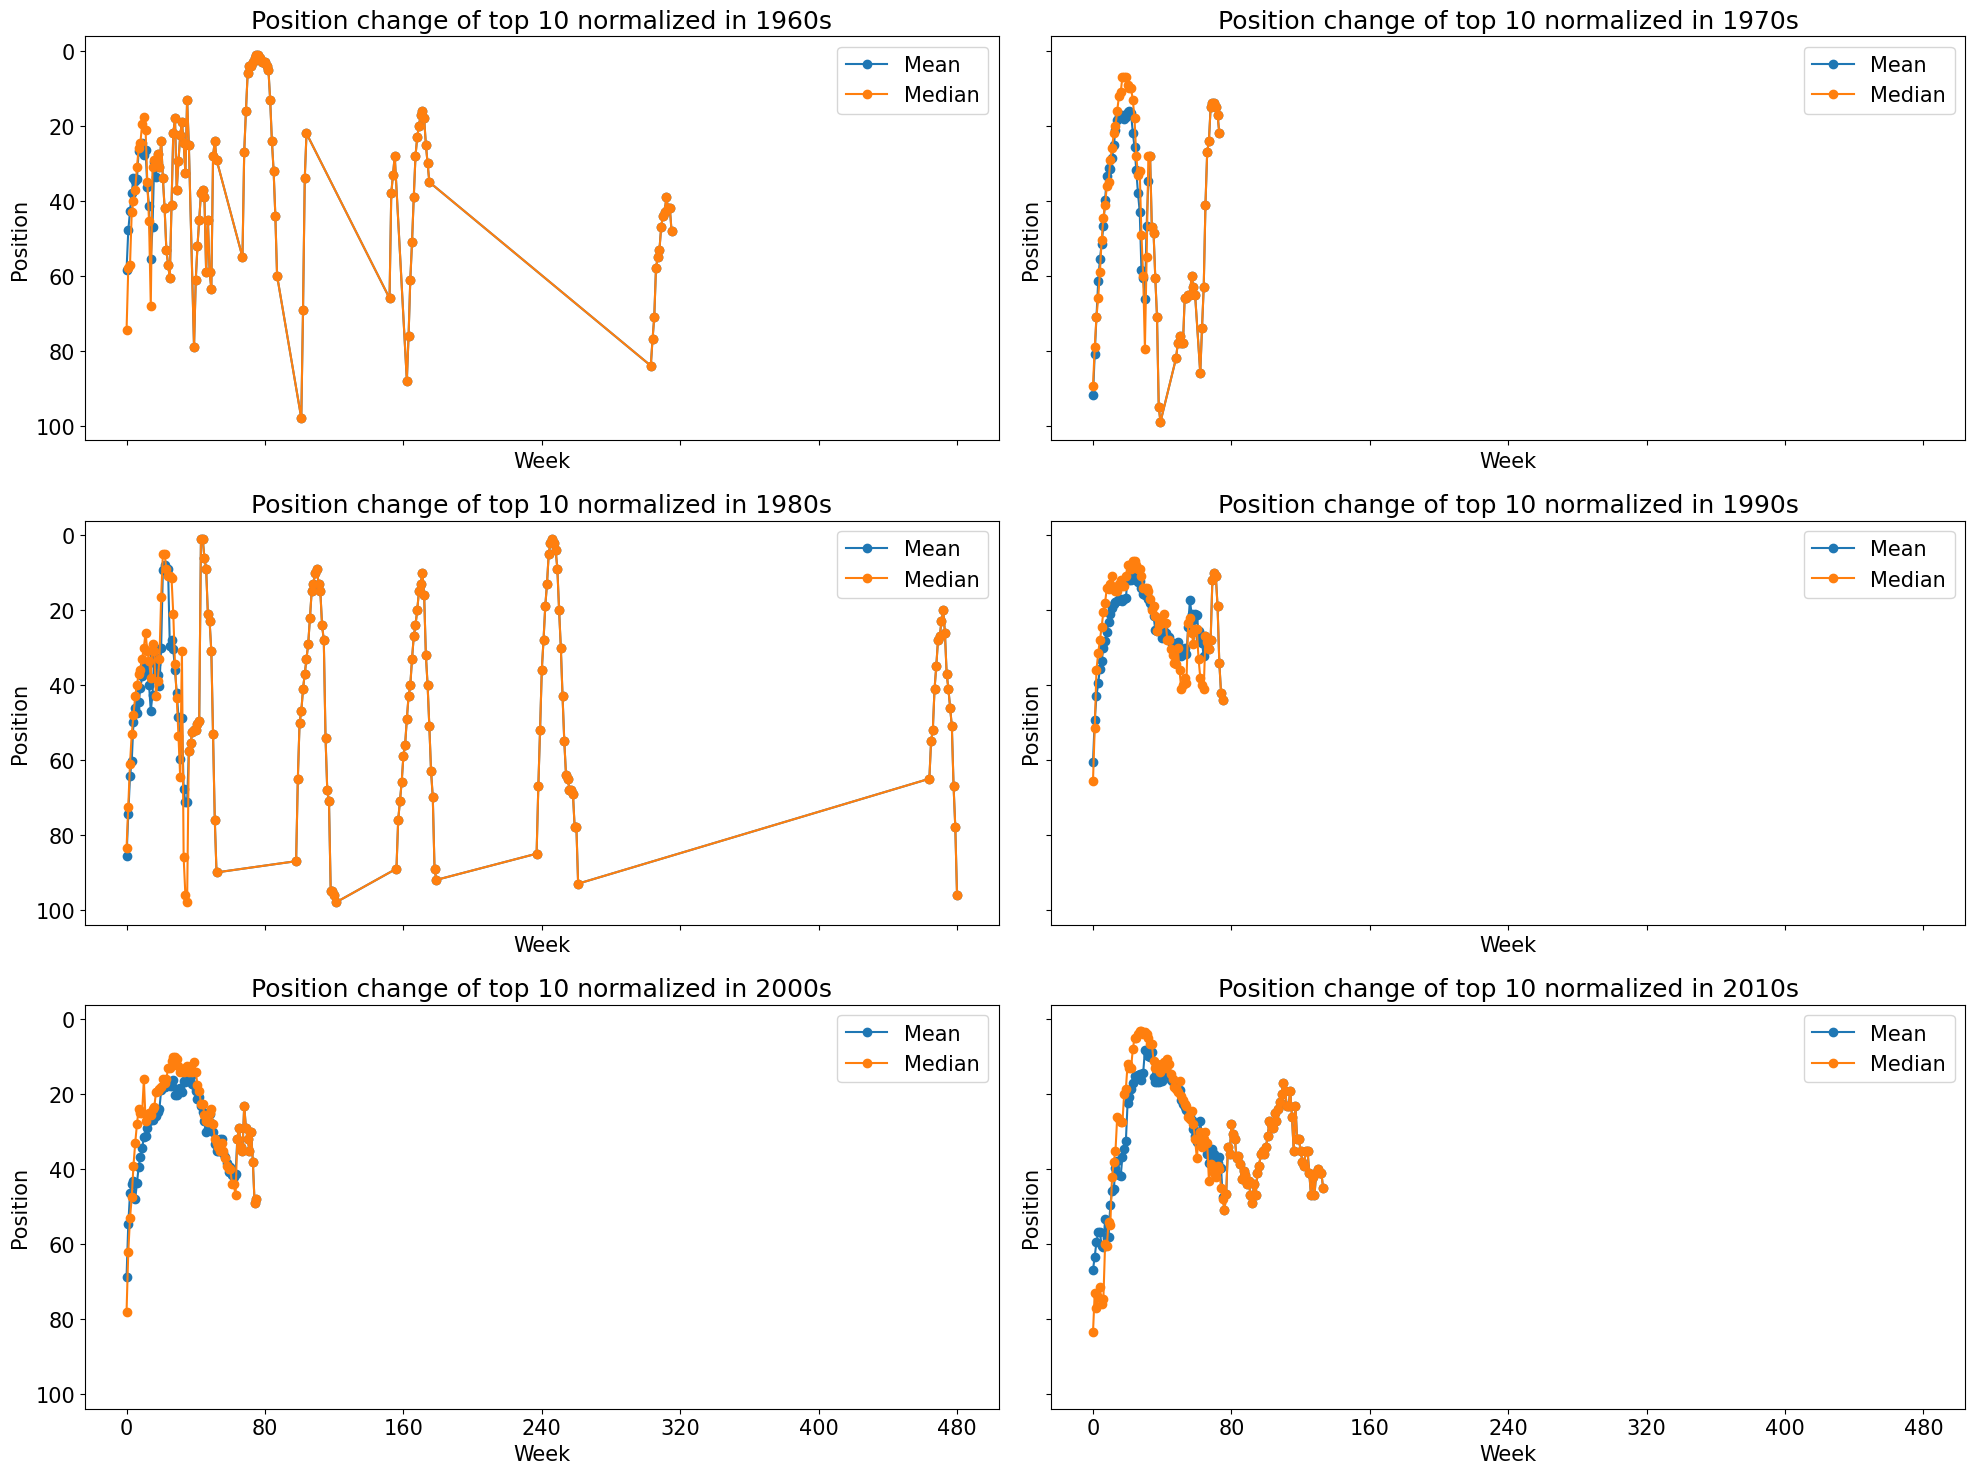

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade.sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)], on=["artist", "song_name"], how="left")
    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    min_first_week = top_10_decade_positions.index.min().to_pydatetime()

    # subtract first week difference from all first days of the week
    grouped = top_10_decade_positions.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        for row_index, row in group.iterrows():
            row["first_day_of_the_week"] = int(((min_first_week + datetime.timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append(row)

    top_10_decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')
    
    axes[row_i, col_i].set_title(f"Position change of top 10 normalized in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(8))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_decade_normalized.pdf", format="pdf")
plt.show()

### Taking into consideration years before and after the decade

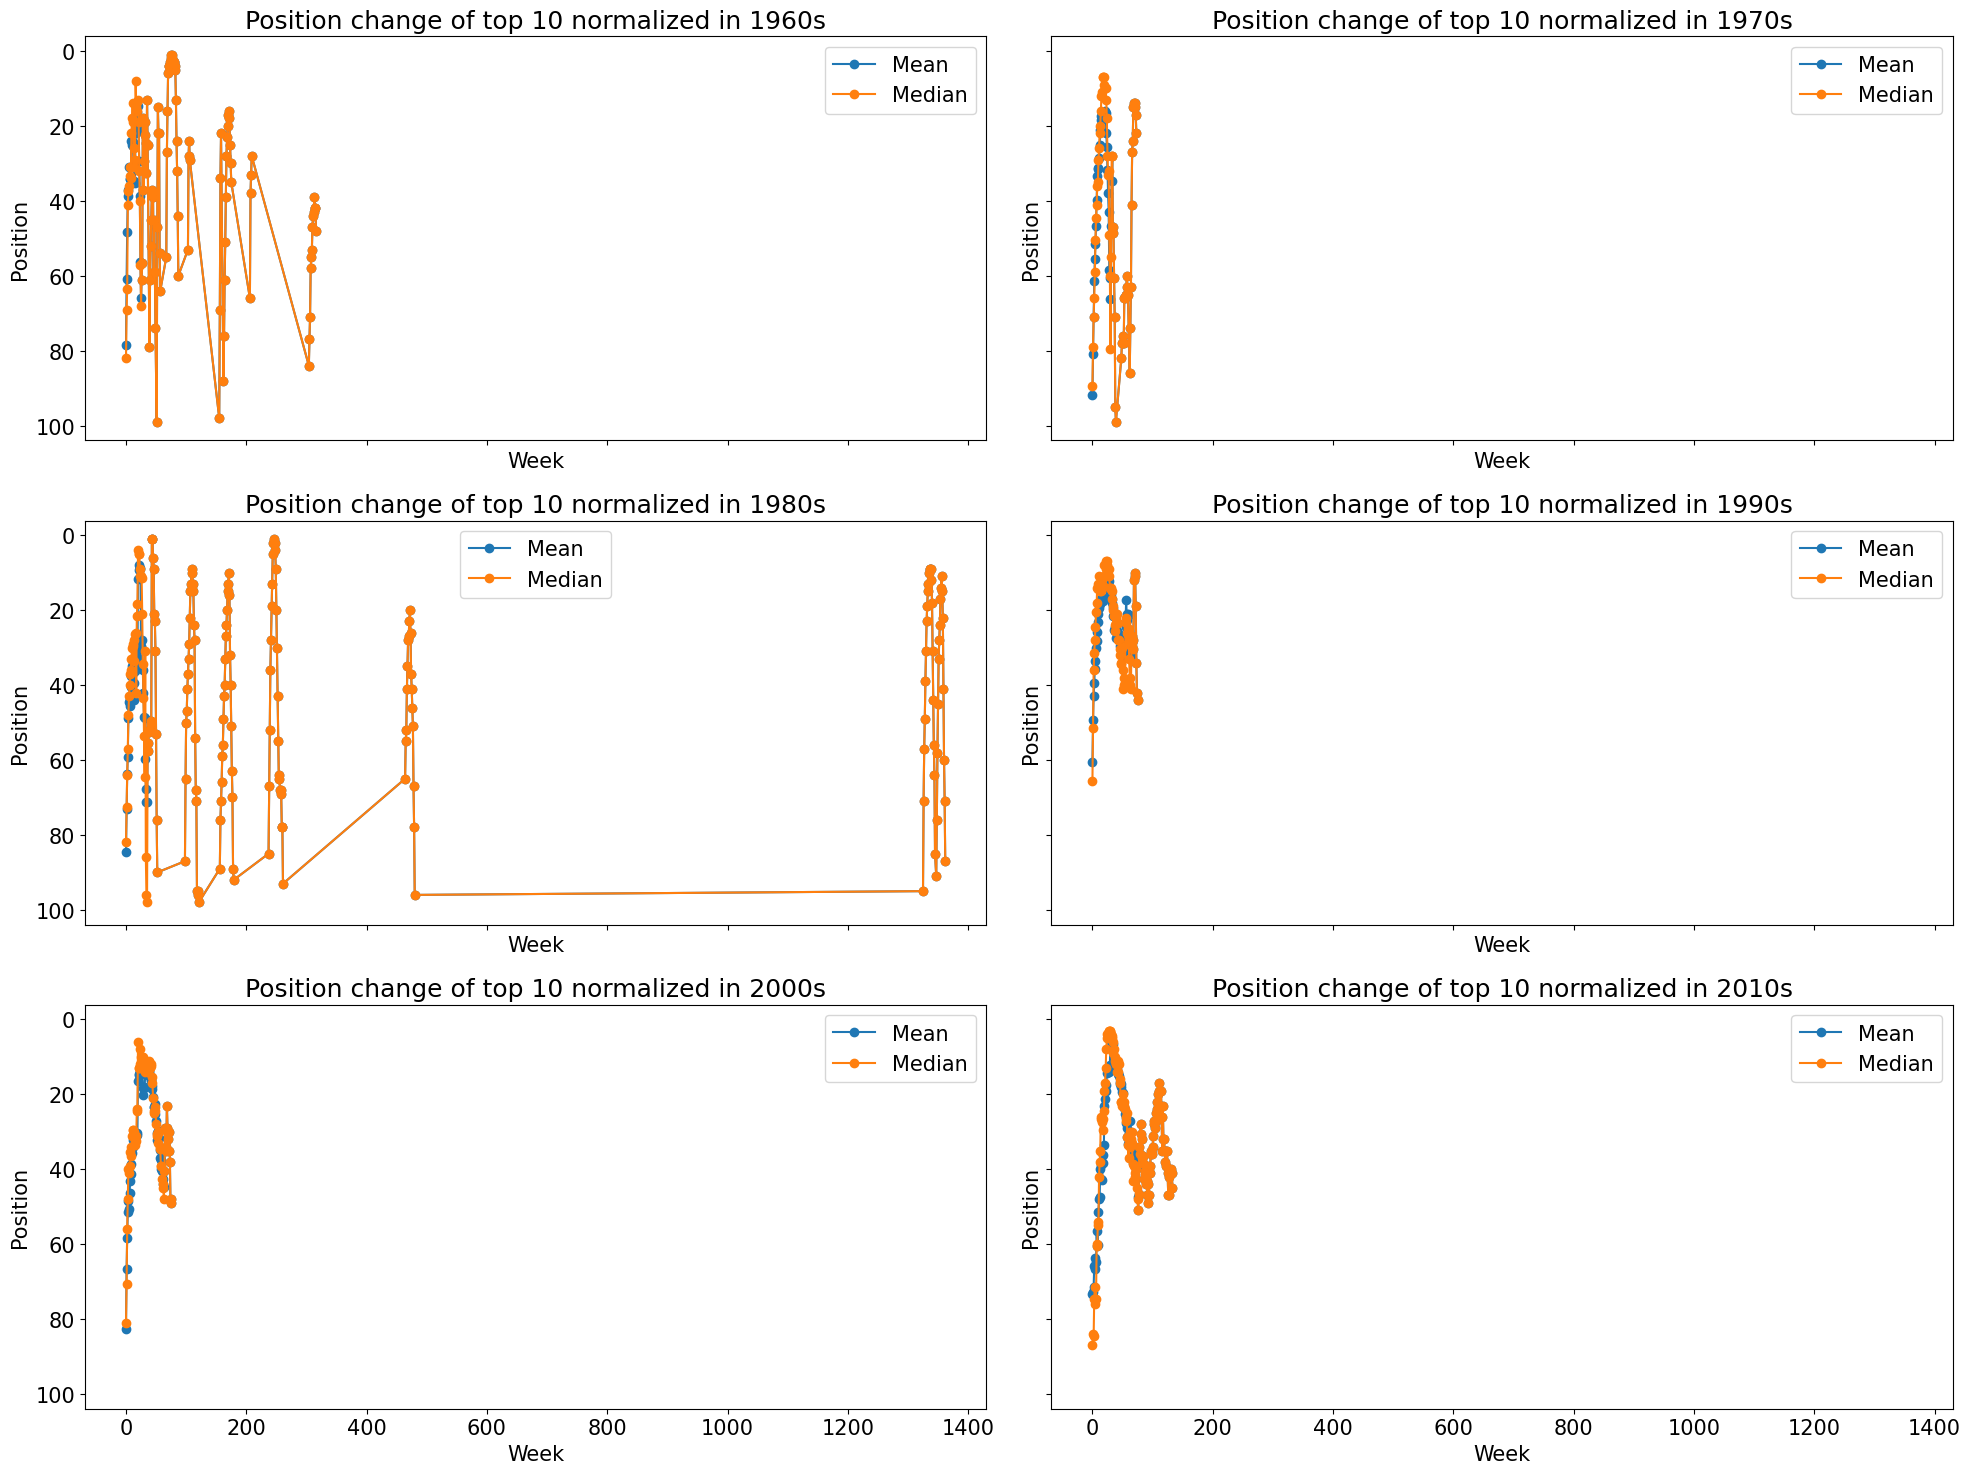

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade.sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100, on=["artist", "song_name"], how="left")
    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    min_first_week = top_10_decade_positions.index.min().to_pydatetime()

    # subtract first week difference from all first days of the week
    grouped = top_10_decade_positions.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        for row_index, row in group.iterrows():
            row["first_day_of_the_week"] = int(((min_first_week + datetime.timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append(row)

    top_10_decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')
    
    axes[row_i, col_i].set_title(f"Position change of top 10 normalized in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(8))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_decade_normalized_all_years.pdf", format="pdf")
plt.show()

## Projection trajectory of a song normalized from top 100 for decades

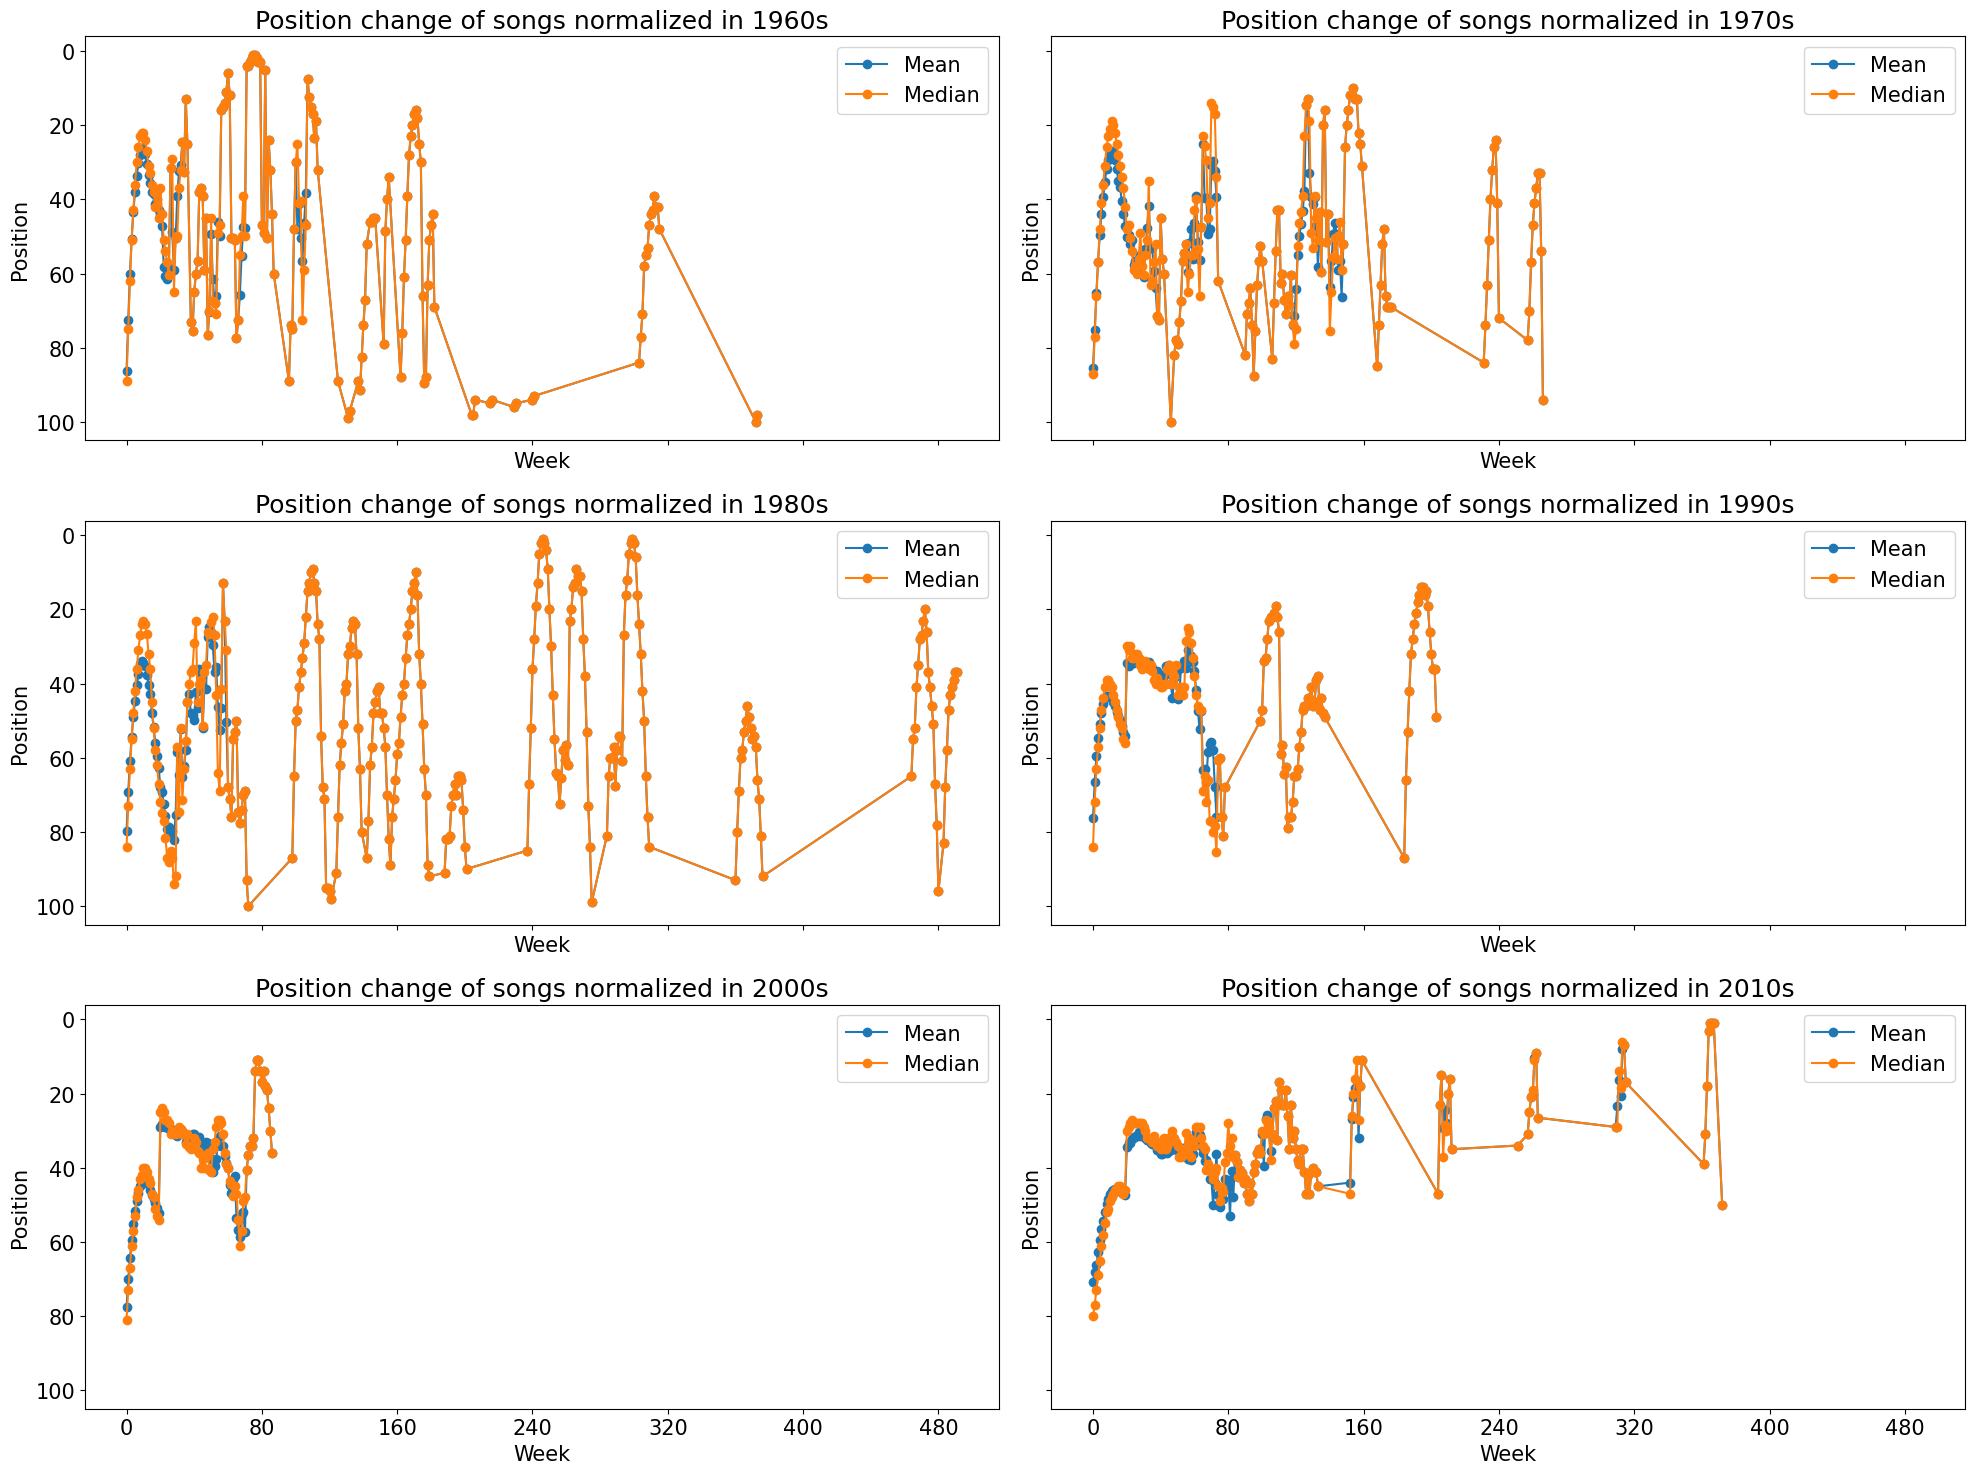

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)]

    decade_positions = all_songs_in_decade[["first_day_of_the_week", "position", "artist", "song_name"]]
    decade_positions.set_index("first_day_of_the_week", inplace=True)

    min_first_week = decade_positions.index.min().to_pydatetime()

    # subtract first week difference from all first days of the week
    grouped = decade_positions.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        for row_index, row in group.iterrows():
            row["first_day_of_the_week"] = int(((min_first_week + datetime.timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append(row)

    decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(decade_positions_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')
    
    axes[row_i, col_i].set_title(f"Position change of songs normalized in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(8))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_100_decade_normalized.pdf", format="pdf")
plt.show()

### Taking into consideration years before and after the decade

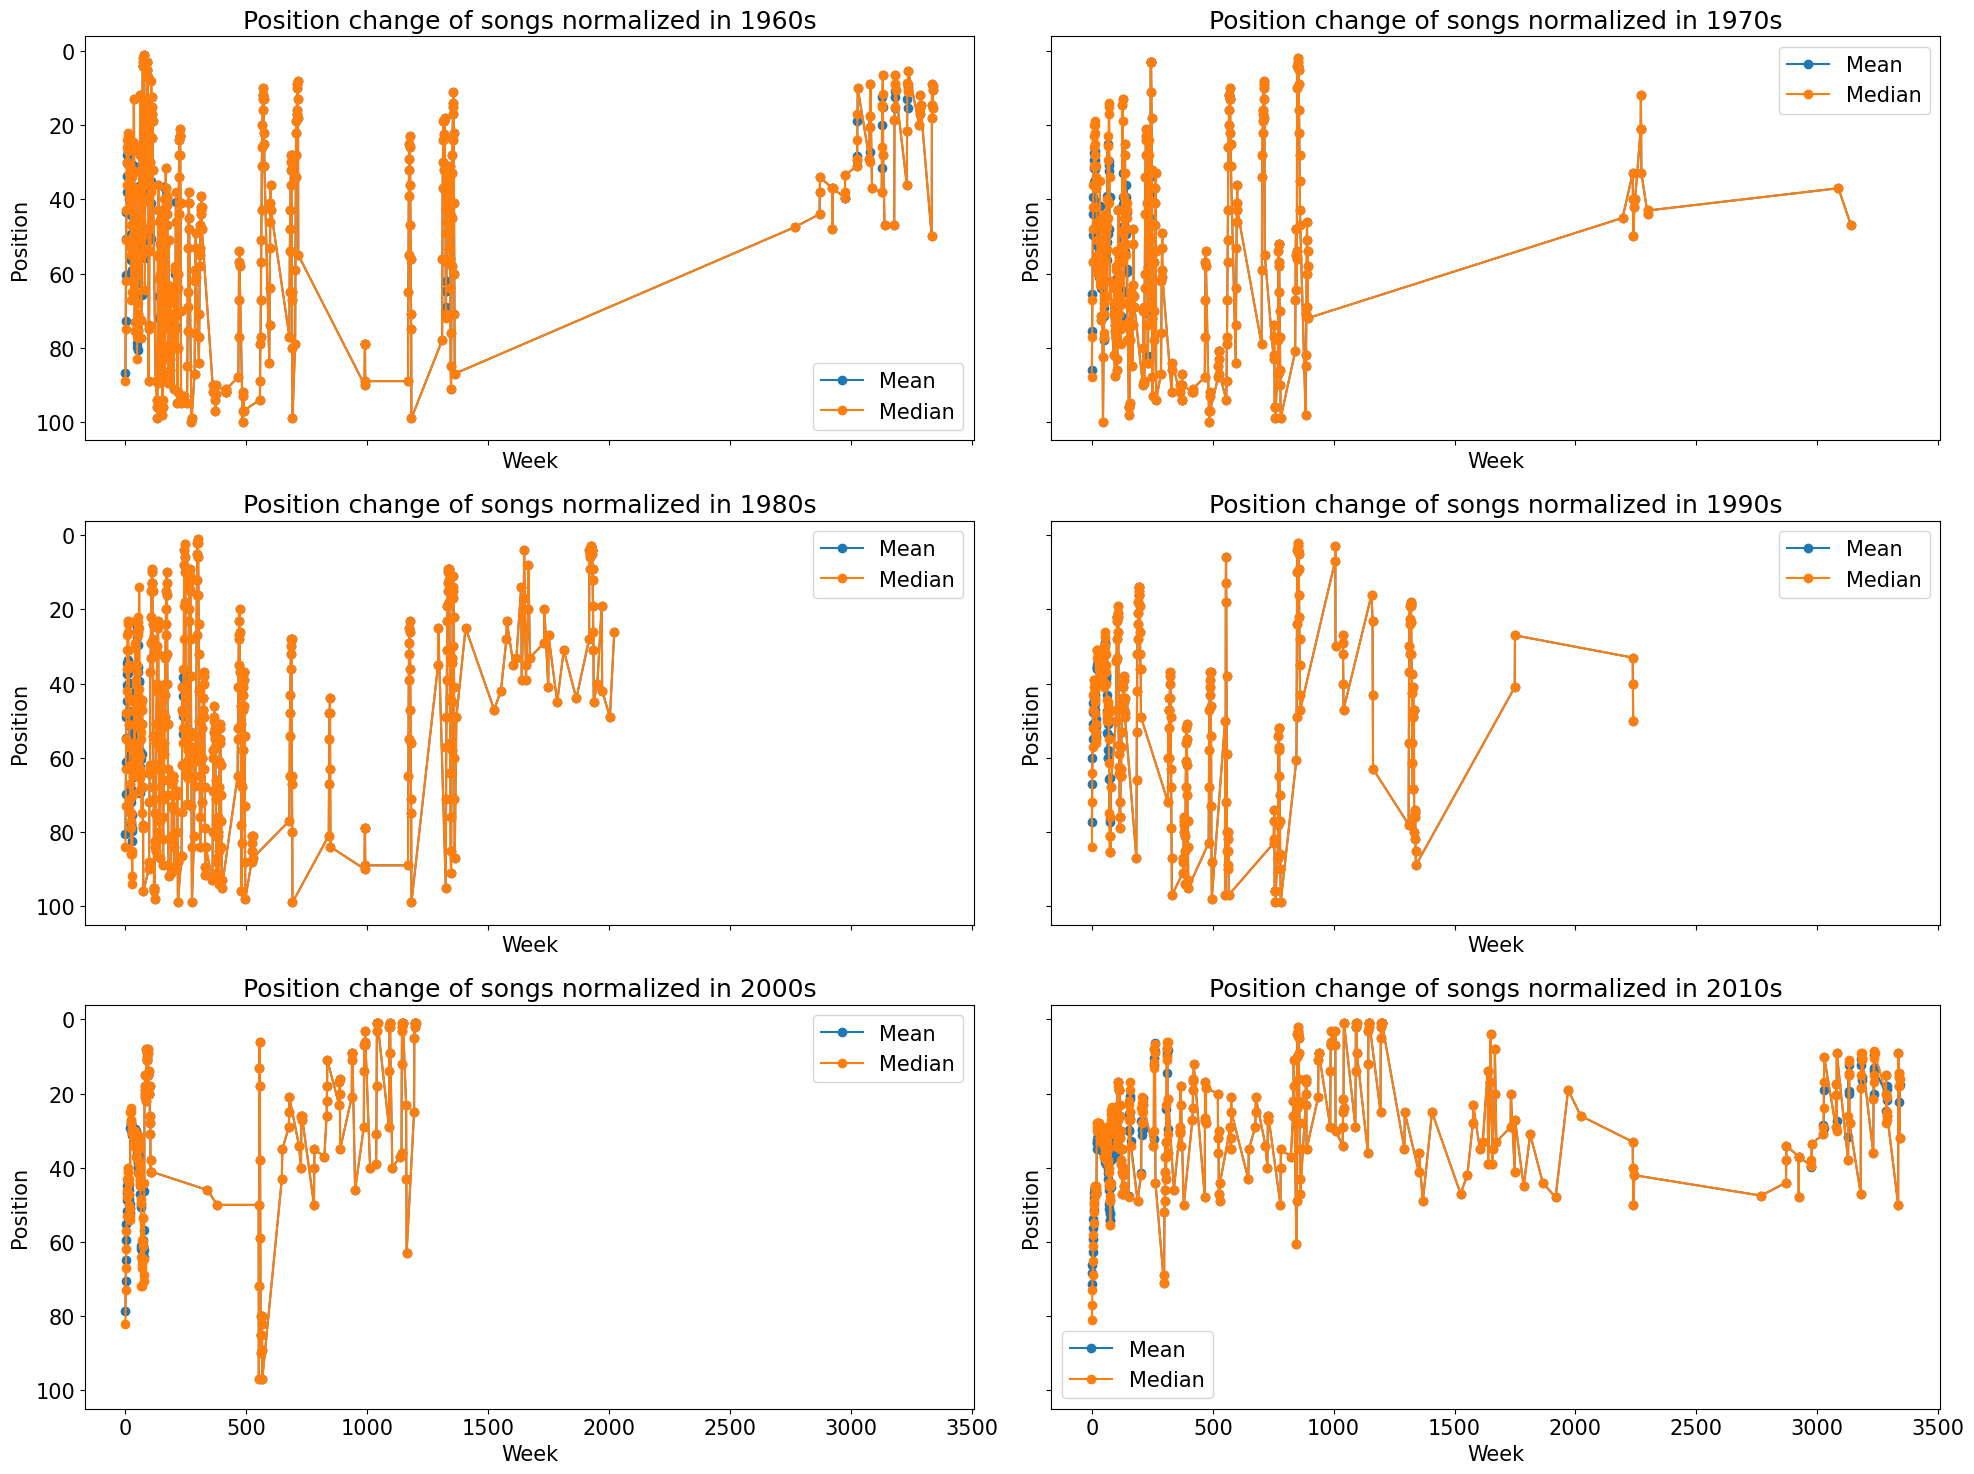

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).first().reset_index()

    decade_positions = all_songs_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100, on=["artist", "song_name"], how="left")
    decade_positions.set_index("first_day_of_the_week", inplace=True)

    min_first_week = decade_positions.index.min().to_pydatetime()

    # subtract first week difference from all first days of the week
    grouped = decade_positions.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        for row_index, row in group.iterrows():
            row["first_day_of_the_week"] = int(((min_first_week + datetime.timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append(row)

    decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(decade_positions_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')
    
    axes[row_i, col_i].set_title(f"Position change of songs normalized in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(8))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_100_decade_normalized_all_years.pdf", format="pdf")
plt.show()

## Max weeks on charts distribution for decades

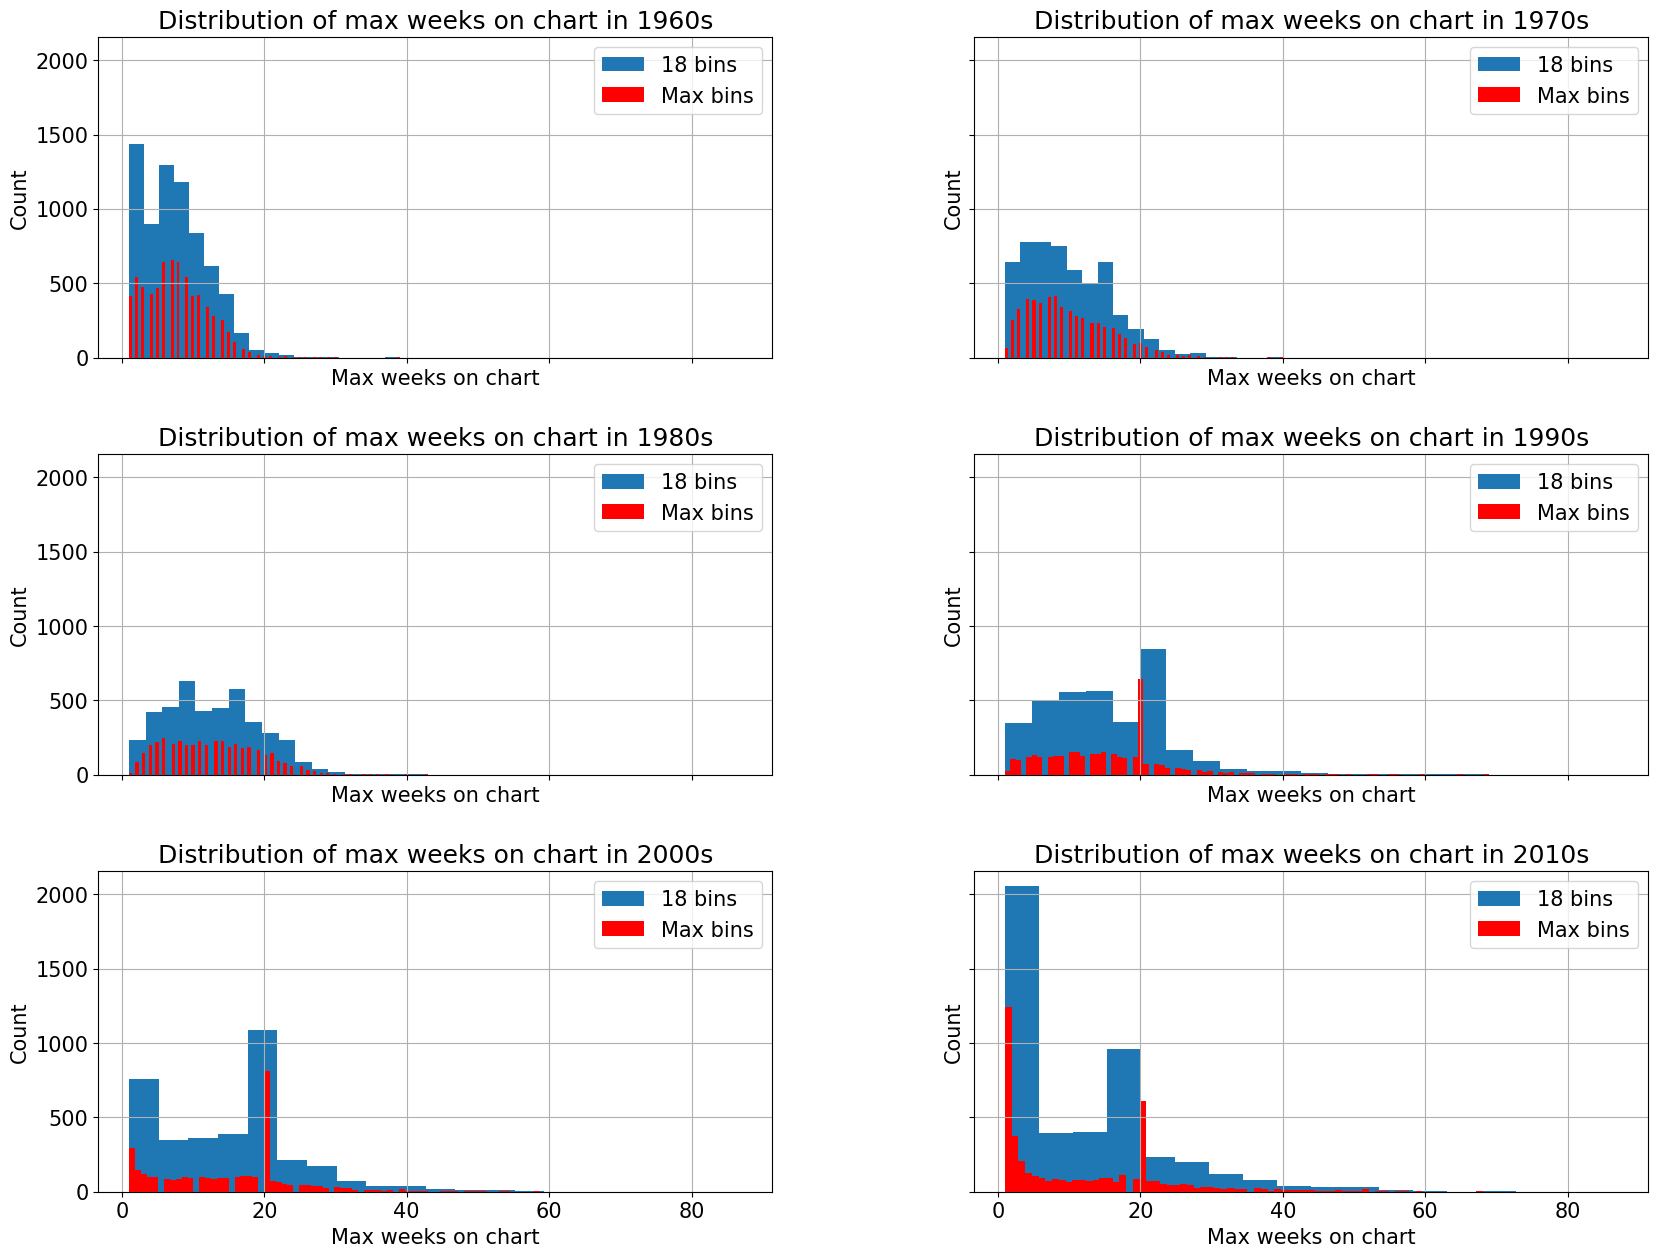

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]]

    max_weeks_on_chart = all_songs_in_decade[["artist", "song_name", "weeks_on_chart"]].groupby(
        by=["artist", "song_name"]).max().reset_index()

    # axes[row_i, col_i].hist(max_weeks_on_chart["weeks_on_chart"], bins=18)
    # axes[row_i, col_i].hist(max_weeks_on_chart["weeks_on_chart"], bins=billboard_hot_100["weeks_on_chart"].max())
    max_weeks_on_chart.hist(bins=18, figsize=(12, 8), legend=False, ax=axes[row_i, col_i])
    max_weeks_on_chart.hist(bins=billboard_hot_100["weeks_on_chart"].max(), figsize=(12, 8), legend=False, color="red", ax=axes[row_i, col_i])

    axes[row_i, col_i].set_title(f"Distribution of max weeks on chart in {year}s")
    axes[row_i, col_i].set_xlabel("Max weeks on chart")
    axes[row_i, col_i].set_ylabel("Count")
    axes[row_i, col_i].legend(["18 bins", "Max bins"])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.savefig("figures/max_weeks_on_chart_distribution_decades.pdf", format="pdf")
plt.show()
